# Random Forest Classifier

By Steven Sison on December 16, 2023

## Description

This document will be used for the preliminary training and evaluation of the random forest classifier. The document includes the necessary processes taken to train the model with the default hyperparameters. This also evaluates the performance of the classifier in terms of accuracy, precision, recall, F1-score, training time, and detection time. Furthermore, this document will only use lexical features and will observe the effect of increasing the number of features used in the model. As this is only for preliminary work, no optimizations, except a simple train-test validation, will be carried out.

### Preliminaries

In [67]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime

dataset = pd.read_csv("temp_unbalanced_withFeatures.csv")      # Loading the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)

## Model Training and Evaluation

### Base Model using All Lexical Features Generated

In [68]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [69]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     26570
           1       0.84      0.84      0.84      6347
           2       0.63      0.60      0.61      7126
           3       0.62      0.47      0.54      1011

    accuracy                           0.84     41054
   macro avg       0.75      0.71      0.73     41054
weighted avg       0.84      0.84      0.84     41054



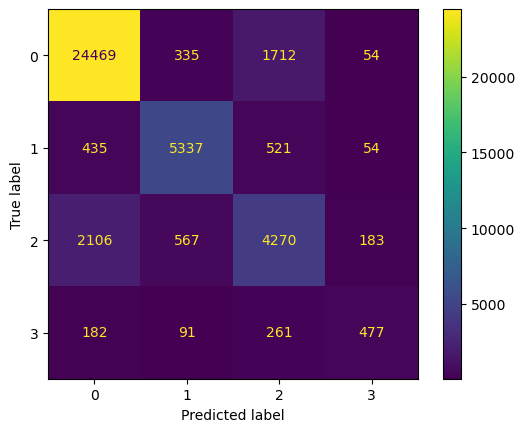

In [70]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Balanced and Unbalanced Datasets

In [71]:
dataset['url_type'].value_counts()

url_type
0    132420
2     35655
1     32067
3      5124
Name: count, dtype: int64

In [72]:
# Upsampling

from sklearn.utils import resample

dataset_benign = dataset[(dataset['url_type'] == 0)]
dataset_defacement = dataset[(dataset['url_type'] == 1)]
dataset_phishing = dataset[(dataset['url_type'] == 2)]
dataset_malware = dataset[(dataset['url_type'] == 3)]

dataset_defacement_upsampled = resample(dataset_defacement,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_phishing_upsampled = resample(dataset_phishing,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_malware_upsampled = resample(dataset_malware,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_upsampled = pd.concat([dataset_benign, dataset_defacement_upsampled, dataset_malware_upsampled, dataset_phishing_upsampled])

# dataset_upsampled.info(0)
dataset_upsampled['url_type'].value_counts()

url_type
0    132420
1    132420
3    132420
2    132420
Name: count, dtype: int64

In [73]:
x_up_train, x_up_test, y_up_train, y_up_test = train_test_split(dataset_upsampled.drop(columns=['url_type']), dataset_upsampled['url_type'], test_size = 0.2, random_state=42)

pipeline_up = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline_up.fit(x_up_train, y_up_train)
y_up_pred = pipeline_up.predict(x_up_test)
print(classification_report(y_up_test, y_up_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     26415
           1       0.95      0.95      0.95     26618
           2       0.89      0.92      0.91     26413
           3       0.95      1.00      0.97     26490

    accuracy                           0.94    105936
   macro avg       0.94      0.94      0.94    105936
weighted avg       0.94      0.94      0.94    105936



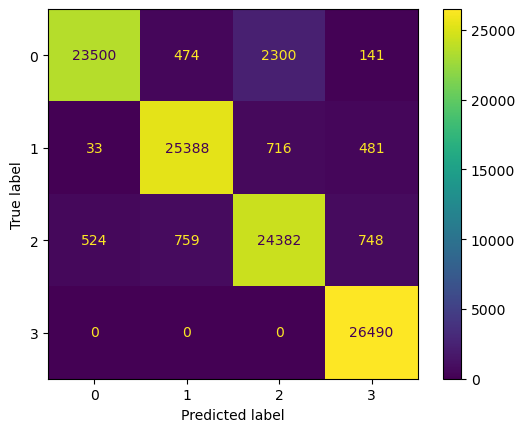

In [74]:
cm_up = confusion_matrix(y_up_test, y_up_pred, labels=pipeline_up.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = pipeline_up.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Adding more Lexical Features

In [75]:
results = []

for i in range(4):
    pipeline = Pipeline([('classifier', RandomForestClassifier())])

    temp_url_features = x_train.iloc[:, 0:(4*(i+1))]

    start = time.perf_counter()
    pipeline.fit(temp_url_features, y_train)
    end = time.perf_counter()

    training_time = end-start
    url_type_predict = pipeline.predict(x_test.iloc[:, 0:(4*(i+1))])

    average_prediction_time = (end-start)/(x_test.shape[0])

    accuracy = accuracy_score(y_test, url_type_predict)
    recall = recall_score(y_test, url_type_predict, average = 'weighted')
    precision = precision_score(y_test, url_type_predict, average = 'weighted', zero_division=1)
    f1 = f1_score(y_test, url_type_predict, average = 'weighted')
    results.append(((4*(i+1)), accuracy, recall, precision, f1, training_time))

In [76]:
results = pd.DataFrame(results, columns=['Number of Features', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'Training Time'])
results = results.sort_values(by='Number of Features', ascending=True)
print(results)

   Number of Features  Accuracy    Recall  Precision  F1-Score  Training Time
0                   4  0.697764  0.697764   0.669360  0.670092      18.042397
1                   8  0.795123  0.795123   0.787136  0.789909      19.849786
2                  12  0.837263  0.837263   0.832742  0.834486      19.739642
3                  16  0.841623  0.841623   0.837574  0.839180      22.445592


Observations:
- Increasing the number of features improves all the class weighted metrics of the model at the cost of a higher training time.